# Celebrity Look a Like CNN DL Project

#### Mohamed Youssef - 211001821

## Index

-   [Including Necessary Libraries](#libs)
    <br>
-   [Other Utilites](#uti)
    <br>
-   [Loading & Cleaning the Data](#dataset)
    - [Downloading the Training Dataset](#download)
    - [Reading the Training Meta Data](#train_metadata)
    - [Reading the Testing Meta Data](#test_metadata)
    - [Creating the Training Data Frame](#train_dataframe)
    - [Creating the Testing Data Frame](#test_dataframe)
    - [Cleaning the Training Data Frame](#clean)
    <br>
-   [Data Visualization](#vis)
    -   [Univariate Exploration](#univis)
    -   [Bivariate Exploration](#bivis)
    <br>
-   [Preprocessing the Data](#pre)
    -   [Getting Training Images Pixels](#train_pix)
    -   [Getting Testing Images Pixels](#test_pix)
    -   [Finding the Training Faces Representations](#train_norm)
    -   [Finding the Testing Faces Representations](#test_norm)
    <br>
-   [Neural Network Construction](#cnn)
    -   [Building the Network (Vgg Face Descriptor)](#bld)
    -   [Importing the Model's Weights](#wghts)
    <br>
-   [Predicting the Faces' Feature Map](#map)
    -   [Predicting the Faces' Feature Map for the Training Images](#train_map)
    -   [Predicting the Faces' Feature Map for the Testing Images](#test_map)
    <br>
-   [Finding Similarities Between the Images](#sim)
    -   [Finding Similarities between the Celebrities & the Testing Images](#test_sim)
    -   [Finding Similarities between the Celebrities & Each Other](#train_sim)
    <br>
-   [Getting the Predictions in Real Time](#real_time)


## Including Necessary Libraries<a id='libs'></a>


In [1]:
# Disable warnings (comment this cell to turn on warnings)
import warnings
import logging


def warn(*args, **kwargs):
    pass


warnings.warn = warn
logging.getLogger("tensorflow").disabled = True

In [2]:
from datetime import datetime, timedelta  # For dealing with ages
import time  # For measuring time taken to run specific cells
import glob  # For getting testing images paths

import chime  # For making a sound when there is an error

import scipy.io  # For loading .mat files
import numpy as np  # For dealing with arrays and matrices
import pandas as pd  # For dealing with dataframes

import matplotlib.pyplot as plt  # For plotting images and graphs
import matplotlib.patches as mpatches  # For drawing shapes in the legend

import cv2  # For image processing
import keras.preprocessing.image as image  # For turning images into arrays

# For building the CNN model
from keras.models import Sequential
from keras.layers import (
    Dropout,
    Flatten,
    Convolution2D,
    ZeroPadding2D,
    MaxPooling2D,
)

import tensorflow as tf  # For configuring the GPU

## Other Utilites<a id='uti'></a>


In [3]:
# Setting the path to the dataset
dataset_path = "C:/Data Sets/CLA Dataset"
print("Dataset path is: " + dataset_path)

Dataset path is: C:/Data Sets/CLA Dataset


In [4]:
# Configuring the GPU for training the model

gpus = tf.config.list_physical_devices("GPU")  # Getting the list of GPUs available

# If there is a GPU available, then set the GPU to be used for training the model
if gpus:
    print("GPUs Available: ", gpus)

    # If there are two GPUs available, then use the second GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[1], "GPU")
        tf.config.experimental.set_memory_growth(gpus[1], True)

    # If there is only one GPU available, then use the first GPU
    except:
        tf.config.experimental.set_visible_devices(gpus[0], "GPU")
        tf.config.experimental.set_memory_growth(gpus[0], True)

# If there is no GPU available, then use the CPU
else:
    print("No GPU Available")

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
# Initializing chime
chime.theme("mario")
chime.notify_exceptions()

## Loading & Cleaning the Data <a id='dataset'></a>


### Downloading the Training Dataset <a id='download'></a>

In [6]:
# Set to True if you want to download the training dataset
download_dataset = False

In [7]:
# Downloading the imdb_crop dataset from the link into the current/Data directory
if download_dataset == False:
    print("Dataset not downloaded. Please download the dataset, if you already have the dataset ignore this message.")
else:
    !wget -P "{dataset_path}" https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar

Dataset not downloaded. Please download the dataset, if you already have the dataset ignore this message.


In [8]:
# Extracting the training dataset from the tar file
if download_dataset == False:
    print("Dataset not extracted. Please extract the dataset, if you already have the dataset extracted ignore this message.")
else:
    !tar -xvf "{dataset_path}"/imdb_crop.tar -C "{dataset_path}"/imdb_crop

Dataset not extracted. Please extract the dataset, if you already have the dataset extracted ignore this message.


### Reading the Training Meta Data <a id='train_metadata'></a>

In [9]:
# Loading the mat file containing the training data
data_mat = scipy.io.loadmat(dataset_path + "/imdb_crop/imdb_crop/imdb.mat")

In [10]:
# Getting the total number of records in the training data
train_records_len = data_mat["imdb"][0][0][0].shape[1]
print("Total number of records:", train_records_len)

Total number of records: 460723


In [11]:
# Getting the column names of the training data
features = data_mat["imdb"][0][0].dtype
features = list(features.names)
train_features_len = len(features)
print("Total number of features:", train_features_len)

Total number of features: 10


In [12]:
# Renaming the training data features for better readability
print("Old Features Names:")
for i in range(0, train_features_len, 2):
    print(features[i], ",", features[i + 1])

features[0] = "Date of Birth"
features[1] = "Photo Taken Date"
features[2] = "Full Img Path"
features[3] = "Gender"
features[4] = "Celebrity Name"
features[5] = "Face Location"
features[6] = "Face Score"
features[7] = "Second Face Score"
features[8] = "Celeb Names"
features[9] = "Celeb ID"

print()

print("New Features Names:")
for i in range(0, train_features_len, 2):
    print(features[i], ",", features[i + 1])

Old Features Names:
dob , photo_taken
full_path , gender
name , face_location
face_score , second_face_score
celeb_names , celeb_id

New Features Names:
Date of Birth , Photo Taken Date
Full Img Path , Gender
Celebrity Name , Face Location
Face Score , Second Face Score
Celeb Names , Celeb ID


### Reading the Testing Meta Data <a id='test_metadata'></a>

In [13]:
# Getting the test images paths
test_imgs_paths = glob.glob(dataset_path + "/test_images/*.*")
print("Total number of test images:", len(test_imgs_paths))

Total number of test images: 28


In [14]:
# Replacing the backslash with forward slash in the test images paths
test_imgs_paths = [path.replace("\\", "/") for path in test_imgs_paths]

print("Test images paths:")
for i in range(0, len(test_imgs_paths), 2):
    print(test_imgs_paths[i], "\t\t", test_imgs_paths[i + 1])

Test images paths:
C:/Data Sets/CLA Dataset/test_images/Abdelrahman Saaed_20_1_1.jpg 		 C:/Data Sets/CLA Dataset/test_images/Abdelrahman Saaed_20_1_2.jpg
C:/Data Sets/CLA Dataset/test_images/Abdelrahman Saaed_20_1_3.jpg 		 C:/Data Sets/CLA Dataset/test_images/Abdulrahman Khaled_20_1_1.jpg
C:/Data Sets/CLA Dataset/test_images/Begad Tamim_20_1_1.jpg 		 C:/Data Sets/CLA Dataset/test_images/Belal Sameh_19_1_1.jpg
C:/Data Sets/CLA Dataset/test_images/Fouad Ouda_20_1_1.jpg 		 C:/Data Sets/CLA Dataset/test_images/Fouad Ouda_20_1_2.jpg
C:/Data Sets/CLA Dataset/test_images/Fouad Ouda_20_1_3.jpg 		 C:/Data Sets/CLA Dataset/test_images/Hazem Metwalli_20_1_1.jpg
C:/Data Sets/CLA Dataset/test_images/Hazem Metwalli_20_1_2.jpg 		 C:/Data Sets/CLA Dataset/test_images/Karol Michel_21_0_1.jpg
C:/Data Sets/CLA Dataset/test_images/Karol Michel_21_0_2.jpg 		 C:/Data Sets/CLA Dataset/test_images/Mohamed Abdelraheem_19_1_1.jpg
C:/Data Sets/CLA Dataset/test_images/Mohamed Refaat_19_1_1.jpg 		 C:/Data Sets/CLA

In [15]:
# Extracting the names from the test image path
test_imgs_names = []
for path in test_imgs_paths:
    test_imgs_names.append(path.split("/")[-1].split(".")[0].split("_")[0])

print("Test images names:")
for i in range(0, len(test_imgs_names), 2):
    print(test_imgs_names[i], "\t\t", test_imgs_names[i + 1])

Test images names:
Abdelrahman Saaed 		 Abdelrahman Saaed
Abdelrahman Saaed 		 Abdulrahman Khaled
Begad Tamim 		 Belal Sameh
Fouad Ouda 		 Fouad Ouda
Fouad Ouda 		 Hazem Metwalli
Hazem Metwalli 		 Karol Michel
Karol Michel 		 Mohamed Abdelraheem
Mohamed Refaat 		 Mohamed Refaat
Mohamed Refaat 		 Mohamed Refaat
Mohamed Youssef 		 Mohamed Youssef
Mohamed Youssef 		 Mohamed Youssef
Mustafa Eslam 		 Mustafa Eslam
Mustafa Eslam 		 Mustafa Eslam
Youssef Ayman 		 Youssef Ayman


In [16]:
# Extrating the ages from the test image path
test_imgs_ages = []
for path in test_imgs_paths:
    test_imgs_ages.append(path.split("/")[-1].split(".")[0].split("_")[1])

print("Test images ages:")
for i in range(0, len(test_imgs_ages), 2):
    print(test_imgs_ages[i], "\t\t", test_imgs_ages[i + 1])

Test images ages:
20 		 20
20 		 20
20 		 19
20 		 20
20 		 20
20 		 21
21 		 19
19 		 19
19 		 19
19 		 19
19 		 19
20 		 20
20 		 20
20 		 20


In [17]:
# Extracting the genders from the test image path
test_imgs_genders = []
for path in test_imgs_paths:
    test_imgs_genders.append(path.split("/")[-1].split(".")[0].split("_")[2])

print("Test images genders:")
for i in range(0, len(test_imgs_genders), 2):
    print(test_imgs_genders[i], "\t\t", test_imgs_genders[i + 1])

Test images genders:
1 		 1
1 		 1
1 		 1
1 		 1
1 		 1
1 		 0
0 		 1
1 		 1
1 		 1
1 		 1
1 		 1
1 		 1
1 		 1
1 		 1


### Creating the Training Data Frame <a id='train_dataframe'></a>

In [18]:
# Creating a dataframe to store the training data
train_df = pd.DataFrame(index=(range(0, train_records_len)), columns=features)

In [19]:
# Extracting the training data from the mat file and storing it in a dataframe
for i in data_mat:
    if i == "imdb":
        current_array = data_mat[i][0][0]
        for j in range(len(current_array)):
            train_df[features[j]] = pd.DataFrame(current_array[j][0])

In [20]:
# Displaying 5 random rows of the training data
train_df.sample(5)

Date of Birth  Photo Taken Date  \
239162         722237              2010   
130449         708890              1997   
45499          712196              2007   
71437          706244              2008   
252044         705581              1962   

                                          Full Img Path  Gender  \
239162    [37/nm0915637_rm1437117184_1977-6-1_2010.jpg]     0.0   
130449  [32/nm0001832_rm4186216704_1940-11-15_1997.jpg]     1.0   
45499    [13/nm0000313_rm1813420800_1949-12-4_2007.jpg]     1.0   
71437     [91/nm0000591_rm246126336_1933-8-18_2008.jpg]     1.0   
252044  [60/nm0320760_rm1288369920_1931-10-25_1962.jpg]     0.0   

               Celebrity Name  \
239162  [Sarah Wayne Callies]   
130449        [Sam Waterston]   
45499          [Jeff Bridges]   
71437        [Roman Polanski]   
252044       [Annie Girardot]   

                                            Face Location  Face Score  \
239162           [[1378.304, 264.192, 1671.168, 557.056]]    3.987493   
130449                                 [[1, 1, 295, 475]]        -inf   
45499   [[160.78556811842654, 69.21324347932567, 201.4...    2.492608   
71437   [[190.42212782941172, 95.55506391470585, 311.7...    5.507890   
252044  [[258.30843151933584, 111.27504207971535, 422....    3.352960   

        Second Face Score Celeb Names  Celeb ID  
239162           2.425624         NaN     17245  
130449                NaN         NaN     17067  
45499                 NaN         NaN      8700  
71437            1.041401         NaN     16622  
252044           2.585260         NaN      1266

In [21]:
# Describing the training data
train_df.describe()

Date of Birth  Photo Taken Date         Gender    Face Score  \
count  460723.000000     460723.000000  452261.000000  4.607230e+05   
mean   718987.731774       2005.461555       0.581996          -inf   
std     13253.963535          9.054475       0.493231           NaN   
min        47.000000       1961.000000       0.000000          -inf   
25%    716370.000000       2004.000000       0.000000  1.757891e+00   
50%    719935.000000       2008.000000       1.000000  2.980097e+00   
75%    723073.000000       2011.000000       1.000000  4.006376e+00   
max    734963.000000       2015.000000       1.000000  7.381689e+00   

       Second Face Score       Celeb ID  
count      213797.000000  460723.000000  
mean            2.452904   10116.802404  
std             1.064432    5742.153266  
min             0.730926       1.000000  
25%             1.583692    5294.000000  
50%             2.355163   10066.000000  
75%             3.228071   14922.000000  
max             6.395435   20284.000000

In [22]:
# Checking for null values in the training data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460723 entries, 0 to 460722
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date of Birth      460723 non-null  int32  
 1   Photo Taken Date   460723 non-null  uint16 
 2   Full Img Path      460723 non-null  object 
 3   Gender             452261 non-null  float64
 4   Celebrity Name     460723 non-null  object 
 5   Face Location      460723 non-null  object 
 6   Face Score         460723 non-null  float64
 7   Second Face Score  213797 non-null  float64
 8   Celeb Names        20284 non-null   object 
 9   Celeb ID           460723 non-null  uint16 
dtypes: float64(3), int32(1), object(4), uint16(2)
memory usage: 28.1+ MB


### Creating the Testing Data Frame <a id='test_dataframe'></a>

In [23]:
# Creating a dataframe to store the testing data
test_df = pd.DataFrame(
    {
        "Name": test_imgs_names,
        "Age at Photo": test_imgs_ages,
        "Full Img Path": test_imgs_paths,
        "Gender": test_imgs_genders,
    }
)

In [24]:
# Displaying 5 random rows of the testing data
test_df.sample(5)

Name Age at Photo  \
23   Mustafa Eslam           20   
6       Fouad Ouda           20   
24   Mustafa Eslam           20   
7       Fouad Ouda           20   
15  Mohamed Refaat           19   

                                        Full Img Path Gender  
23  C:/Data Sets/CLA Dataset/test_images/Mustafa E...      1  
6   C:/Data Sets/CLA Dataset/test_images/Fouad Oud...      1  
24  C:/Data Sets/CLA Dataset/test_images/Mustafa E...      1  
7   C:/Data Sets/CLA Dataset/test_images/Fouad Oud...      1  
15  C:/Data Sets/CLA Dataset/test_images/Mohamed R...      1

In [25]:
# Describing the testing data
test_df.describe()

Name Age at Photo  \
count               28           28   
unique              12            3   
top     Mohamed Refaat           20   
freq                 4           16   

                                            Full Img Path Gender  
count                                                  28     28  
unique                                                 28      2  
top     C:/Data Sets/CLA Dataset/test_images/Abdelrahm...      1  
freq                                                    1     26

In [26]:
# Checking for null values in the testing data
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Name           28 non-null     object
 1   Age at Photo   28 non-null     object
 2   Full Img Path  28 non-null     object
 3   Gender         28 non-null     object
dtypes: object(4)
memory usage: 1.0+ KB


### Cleaning the Training Data Frame<a id='clean'></a>

In [27]:
# Removing pictures with no face detected
train_df = train_df[train_df["Face Score"] != -np.inf]
print(
    "Total number of records with no face detected removed:",
    train_records_len - len(train_df),
)
records_len = len(train_df)  # Updating the total number of records
print(
    "Total number of records after removing records with no face detected:", records_len
)

Total number of records with no face detected removed: 62302
Total number of records after removing records with no face detected: 398421


In [28]:
# Removing pictures with more than one face detected
train_df = train_df[train_df["Second Face Score"].isna()]
print(
    "Total number of records with more than one face detected removed:",
    records_len - len(train_df),
)
train_records_len = len(train_df)  # Updating the total number of records
print(
    "Total number of records after removing pictures with more the one face:",
    train_records_len,
)

Total number of records with more than one face detected removed: 213797
Total number of records after removing pictures with more the one face: 184624


In [29]:
def extract_data(arr):
    """
    Extracts the first element from the given array.

    Parameters:
    -   arr (list or array-like): The array from which to extract the first element.

    Returns:
    -   element: The first element of the input array.
    """
    return arr[0]

In [30]:
# Extracting the data from the array columns of the dataframe
train_df["Celebrity Name"] = train_df["Celebrity Name"].apply(extract_data)
train_df["Full Img Path"] = train_df["Full Img Path"].apply(extract_data)

In [31]:
# Dropping the unnecessary columns from the dataframe
train_df.drop(
    ["Celeb ID", "Celeb Names", "Second Face Score", "Face Location"],
    axis=1,
    inplace=True,
)

In [32]:
# Getting the number of features in the data after dropping unnecessary columns
train_features_len = len(train_df.columns)
print(
    "Total number of features after dropping unnecessary columns:", train_features_len
)

Total number of features after dropping unnecessary columns: 6


In [33]:
# Displaying the first row of the data after dropping unnecessary columns
train_df.head(1)

Date of Birth  Photo Taken Date  \
3         693726              1968   

                                 Full Img Path  Gender Celebrity Name  \
3  01/nm0000001_rm946909184_1899-5-10_1968.jpg     1.0   Fred Astaire   

   Face Score  
3    1.872117

In [34]:
def convert_date(date_number):
    """
    Converts a MATLAB serial date number to a Python datetime object.

    Parameters:
    -   date_number (int or float): The MATLAB serial date number to convert.

    Returns:
    -   datetime or str: The converted date as a datetime object or a string in the format YYYY.
    -   If an OverflowError occurs during conversion, returns pandas NaT (Not a Time) as a placeholder for missing or null date values.
    """
    str_date = str(date_number)

    # If the length of the string is 4, then the date is in the format YYYY
    if len(str_date) == 4:
        full_date = datetime.strptime(str_date, "%Y")
        return full_date.strftime("%Y")

    # If the length of the string is 7, then the date is in the format YYYY.MM
    else:
        try:
            date_time = (
                datetime.fromordinal(int(date_number))
                + timedelta(days=date_number % 1)
                - timedelta(days=366)
            )
            return date_time
        except OverflowError:
            return pd.NaT

In [35]:
# Converting the matlab serial date number to python date time object
train_df["Date of Birth"] = train_df["Date of Birth"].apply(convert_date)

In [36]:
# Converting the Photo Taken Date to python year date time object
train_df["Photo Taken Date"] = train_df["Photo Taken Date"].apply(convert_date)

In [37]:
def calculate_age_at_photo(born, photo_taken):
    """
    Calculates the age of a person at the time a photo was taken.

    Parameters:
    -   born (datetime): The birth date of the person.
    -   photo_taken (str): The year the photo was taken, in the format "YYYY".

    Returns:
    -   int or np.nan: The age of the person at the time the photo was taken. If an AttributeError occurs (e.g., if 'born' is not a datetime object), returns np.nan.
    """
    photo_taken = datetime.strptime(photo_taken, "%Y")
    try:
        return (
            photo_taken.year
            - born.year
            - ((photo_taken.month, photo_taken.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [38]:
# Calculating the age of the celebrity
train_df["Age at Photo"] = train_df.apply(
    lambda x: calculate_age_at_photo(x["Date of Birth"], x["Photo Taken Date"]), axis=1
)
# Changing the datatype of the age column to integer
train_df["Age at Photo"] = train_df["Age at Photo"].astype("Int64")

In [39]:
def calculate_current_age(born):
    """
    Calculates the current age of a person based on their birth date.

    Parameters:
    -   born (datetime): The birth date of the person.

    Returns:
    -   int or np.nan: The current age of the person. If an AttributeError occurs (e.g., if 'born' is not a datetime object), returns np.nan.
    """
    today = datetime.today()
    try:
        return (
            today.year - born.year - ((today.month, today.day) < (born.month, born.day))
        )
    except AttributeError:
        return np.nan

In [40]:
# Calculating the current age of the celebrity
train_df["Current Age"] = train_df["Date of Birth"].apply(calculate_current_age)
# Changing the datatype of the age column to integer
train_df["Current Age"] = train_df["Current Age"].astype("Int64")

In [41]:
# Dropping the Date of Birth and Photo Taken Date columns
train_df.drop(["Date of Birth", "Photo Taken Date"], axis=1, inplace=True)

In [42]:
# Getting the number of features in the data after replacing the date columns
train_features_len = len(train_df.columns)
print("Total number of features after replacing the date columns:", train_features_len)

Total number of features after replacing the date columns: 6


In [43]:
# Displaying the first row of the data after replacing the date columns
train_df.head(1)

Full Img Path  Gender Celebrity Name  \
3  01/nm0000001_rm946909184_1899-5-10_1968.jpg     1.0   Fred Astaire   

   Face Score  Age at Photo  Current Age  
3    1.872117            68          124

In [44]:
# Dropping any rows with null values
train_df.dropna(inplace=True)
print(
    "Total number of records with null values removed:",
    train_records_len - len(train_df),
)
train_records_len = len(train_df)  # Updating the total number of records
print("Total number of records after removing null values:", len(train_df))

Total number of records with null values removed: 2990
Total number of records after removing null values: 181634


In [45]:
# Removing the records with age at photo less than 0
train_df = train_df[train_df["Age at Photo"] >= 0]
print(
    "Total number of records with -ve age removed:", train_records_len - len(train_df)
)
train_records_len = len(train_df)  # Updating the total number of records
print("Total number of records after removing -ve age values:", len(train_df))

Total number of records with -ve age removed: 154
Total number of records after removing -ve age values: 181480


In [46]:
# Changing the datatype of the gender column to integer (1: Male, 0: Female)
train_df["Gender"] = train_df["Gender"].astype(int)

In [47]:
# Reordering the columns of the dataframe
train_df = train_df.reindex(
    columns=[
        "Celebrity Name",
        "Gender",
        "Current Age",
        "Age at Photo",
        "Full Img Path",
        "Face Score",
    ]
)

In [48]:
# Displaying the first row of the data after reordering the columns
train_df.head(1)

Celebrity Name  Gender  Current Age  Age at Photo  \
3   Fred Astaire       1          124            68   

                                 Full Img Path  Face Score  
3  01/nm0000001_rm946909184_1899-5-10_1968.jpg    1.872117

In [49]:
# Keep only unique celebrities in the data with the highest face score
train_df = train_df.sort_values(by=["Face Score"], ascending=False)
train_df.drop_duplicates(subset="Celebrity Name", keep="first", inplace=True)
print(
    "Total number of records with duplicate celebrities removed:",
    train_records_len - len(train_df),
)
train_records_len = len(train_df)  # Updating the total number of records
print("Total number of records after removing duplicate celebrities:", len(train_df))

Total number of records with duplicate celebrities removed: 166870
Total number of records after removing duplicate celebrities: 14610


In [50]:
# Filtering the data to keep only celebrities with a face score of 3 or more
train_df = train_df[train_df["Face Score"] >= 3]
print(
    "Total number of records with low face score removed:",
    train_records_len - len(train_df),
)
train_records_len = len(train_df)  # Updating the total number of records
print("Total number of records after removing low face scores values:", len(train_df))

Total number of records with low face score removed: 3193
Total number of records after removing low face scores values: 11417


In [51]:
# Dropping the Face Score column
train_df.drop(["Face Score"], axis=1, inplace=True)

In [52]:
# Getting the number of features in the data after dropping the Face Score column
train_features_len = len(train_df.columns)
print(
    "Total number of features after dropping the Face Score column:", train_features_len
)

Total number of features after dropping the Face Score column: 5


In [53]:
# Resetting the index of the dataframe
train_df.reset_index(drop=True, inplace=True)

In [54]:
# Displaying 5 random rows of the data
train_df.sample(5)

Celebrity Name  Gender  Current Age  Age at Photo  \
10793  Luca Bercovici       1           66            34   
1502   Adam Rodriguez       1           48            36   
6822    Mark Hildreth       1           45            34   
9750        Toby Huss       1           57            44   
7886      Ross Martin       1          103            44   

                                      Full Img Path  
10793   42/nm0001942_rm997645312_1957-2-22_1992.jpg  
1502    26/nm0735226_rm3981750528_1975-4-2_2012.jpg  
6822   26/nm0383926_rm1076679168_1978-1-24_2013.jpg  
9750   47/nm0403947_rm3114317824_1966-12-9_2011.jpg  
7886   14/nm0553014_rm2288240640_1920-3-22_1965.jpg

In [55]:
# Describing the data
train_df.describe()

Gender   Current Age  Age at Photo
count  11417.000000  11417.000000  11417.000000
mean       0.572304     55.538758     35.960760
std        0.494766     17.627355     14.467294
min        0.000000     16.000000      0.000000
25%        0.000000     43.000000     26.000000
50%        1.000000     53.000000     34.000000
75%        1.000000     65.000000     44.000000
max        1.000000    147.000000    133.000000

In [56]:
# Checking for null values in the data
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11417 entries, 0 to 11416
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Celebrity Name  11417 non-null  object
 1   Gender          11417 non-null  int32 
 2   Current Age     11417 non-null  Int64 
 3   Age at Photo    11417 non-null  Int64 
 4   Full Img Path   11417 non-null  object
dtypes: Int64(2), int32(1), object(2)
memory usage: 423.8+ KB


In [57]:
# Getting the number of features in the data after cleaning
train_features_len = len(train_df.columns)
print("Total number of features after cleaning:", train_features_len)

Total number of features after cleaning: 5


In [58]:
# Getting the total number of records in the data after cleaning
train_records_len = len(train_df)
print("Total number of records after cleaning:", train_records_len)

Total number of records after cleaning: 11417


## Data Visualization <a id="vis"></a>


### Univariate Exploration <a id="univis"></a>


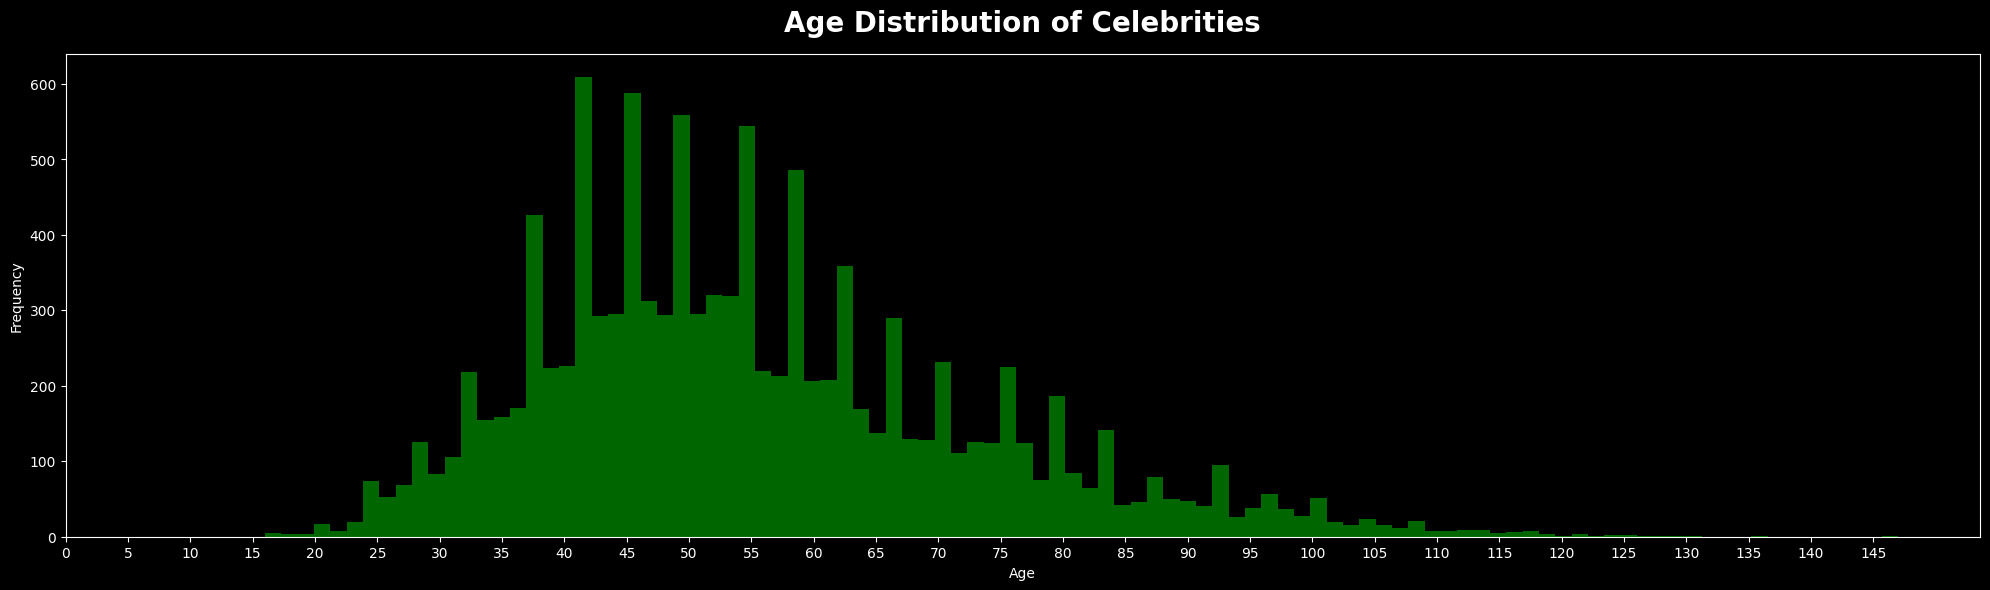

In [59]:
# Plotting the distribution of the age of the celebrities
plt.figure(figsize=(20, 6))
plt.hist(train_df["Current Age"], bins=100, color="green", alpha=0.8)

max_age = train_df["Current Age"].max()  # Getting the maximum age of the celebrities

plt.xticks(range(0, max_age, 5))

plt.xlabel("Age")
plt.ylabel("Frequency")

plt.title("Age Distribution of Celebrities", fontsize=20, fontweight="bold", y=1.03)

plt.tight_layout()
plt.show()

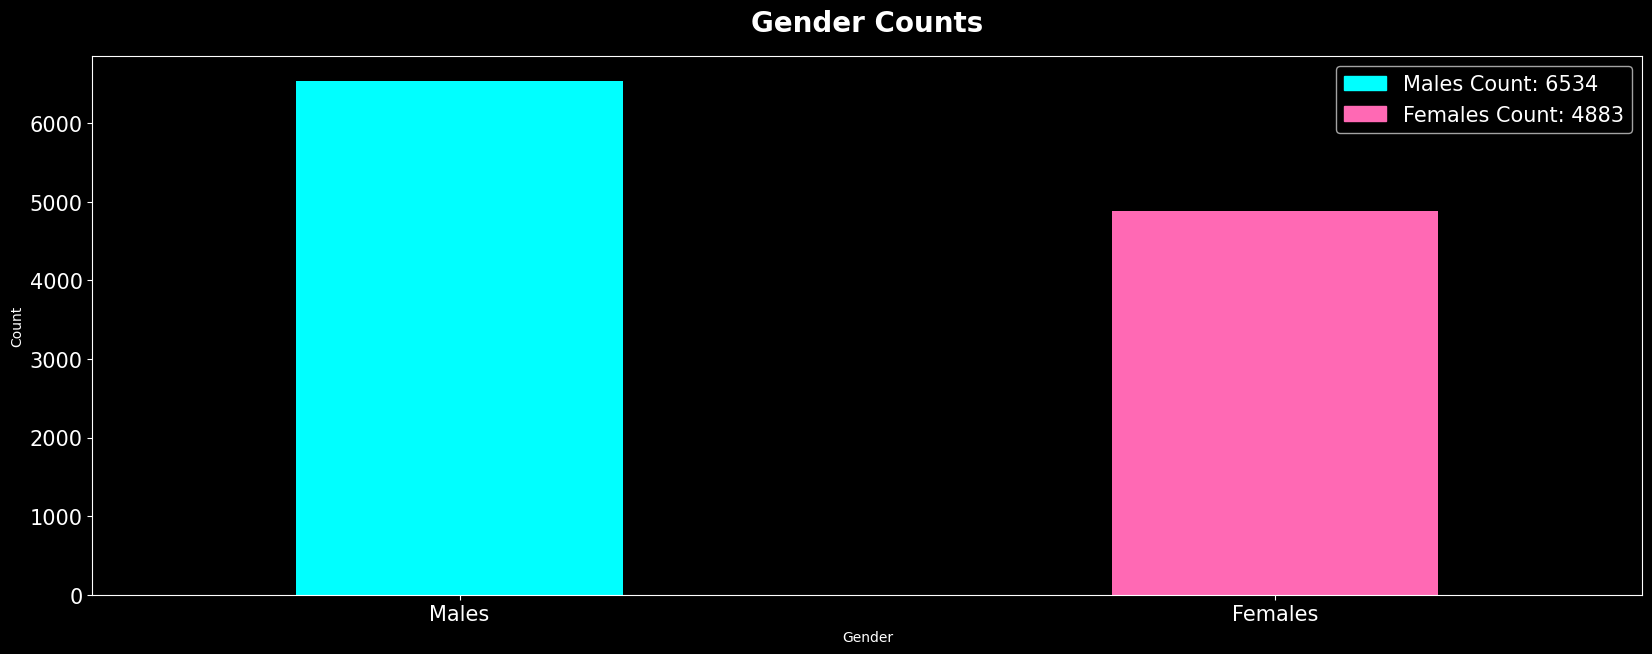

In [60]:
# Plotting the gender counts in the celebrities dataset

gender_counts = train_df[
    "Gender"
].value_counts()  # Getting the number of male and female celebrities in the dataset
gender_counts.rename(
    {0: "Females", 1: "Males"}, inplace=True
)  # Renaming 0s and 1s in the pandas series to Females and Males respectively

plt.figure(figsize=(20, 7))
gender_counts.plot(kind="bar", color=["aqua", "hotpink"], rot=0, width=0.4)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlabel("Gender")
plt.ylabel("Count")

plt.title("Gender Counts", fontsize=20, fontweight="bold", y=1.03)

females_patch = mpatches.Patch(
    color="hotpink", label=f"Females Count: {gender_counts[1]}"
)
males_patch = mpatches.Patch(color="aqua", label=f"Males Count: {gender_counts[0]}")
plt.legend(handles=[males_patch, females_patch], fontsize=15)

plt.show()

### Bivariate Exploration <a id="bivis"></a>


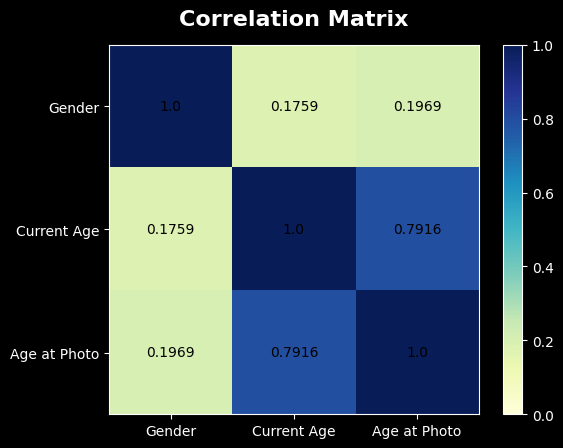

In [61]:
# Plotting the correlation matrix of the data using a heatmap

corr = train_df[
    ["Gender", "Current Age", "Age at Photo"]
].corr()  # Getting the correlation matrix of the data

plt.imshow(corr, cmap="YlGnBu", interpolation="nearest", vmin=0, vmax=1)
plt.colorbar()

for i in range(3):
    for j in range(3):
        plt.annotate(
            str(round(corr.values[i][j], 4)),
            xy=(j, i),
            ha="center",
            va="center",
            color="black",
        )

plt.title("Correlation Matrix", fontsize=16, fontweight="bold", y=1.03)

plt.xticks(range(len(corr.columns)), corr.columns)
plt.yticks(range(len(corr.columns)), corr.columns)

plt.show()

## Preprocessing the Data <a id='pre'></a>


In [62]:
# Checking if the user wants to download the haarcascade_frontalface_default.xml file
download_haarcascade = False

In [63]:
# Downloading the haarcascade_frontalface_default.xml file from the link into the current/Data directory
if download_haarcascade == False:
    print("haarcascade_frontalface_default.xml not downloaded. Please download the file, if you already have the file ignore this message.")
else:
    !wget https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml

haarcascade_frontalface_default.xml not downloaded. Please download the file, if you already have the file ignore this message.


In [64]:
# Loading the face cascade classifier for detecting faces in images
face_cascade = face_cascade = cv2.CascadeClassifier(
    "Models/haarcascade_frontalface_default.xml"
)

In [65]:
i = 1  # Index of the image to be displayed


def load_imgs(path, training=True, verbose=True):
    """
    Load the image pixels from the dataset.

    Parameters:
    -   path (str): The path to the image file.
    -   training (bool): Whether the image is from the training dataset or not.

    Returns:
    -   ndarray: The image pixels as a NumPy array.
    """

    # Printing the image number being loaded if verbose is True
    global i

    if verbose == True:
        print("Loading img number:", i, end="\r")

    i += 1  # Incrementing the image number

    if training == True:
        return cv2.imread(dataset_path + "/imdb_crop/imdb_crop/" + path)
    else:
        return cv2.imread(path)

In [66]:
i = 1  # Index of the image to be displayed


def get_face_representation(img, verbose=True):
    faces = face_cascade.detectMultiScale(
        img, 1.3, 5
    )  # Detecting faces in the image with the face cascade classifier

    detected_face = []  # Initializing an empty list to store the detected face

    # Looping through the x, y, w, h coordinates of the detected faces
    for x, y, w, h in faces:
        detected_face = img[
            int(y) : int(y + h), int(x) : int(x + w)

        ]  # Cropping the face from the image without any margin

        # Trying to crop the face with a margin of 10% of the width and height of the face
        try:
            margin = 10
            margin_x = int((w * margin) / 100)
            margin_y = int((h * margin) / 100)

            detected_face = img[
                int(y - margin_y) : int(y + h + margin_y),

                int(x - margin_x) : int(x + w + margin_x),
            ]
        except:
            pass  # If the margin is too big, then ignore it

    if isinstance(detected_face, np.ndarray) == False or detected_face.size == 0:
        return np.nan

    detected_face = cv2.resize(

        detected_face, (224, 224)
    )  # Resize the detected face to 224x224 pixels

    # Convert image to numpy array of shape (224, 224, 3)
    img_pixels = image.img_to_array(detected_face)
    img_pixels = np.expand_dims(img_pixels, axis=0)

    # Normalize the image pixels to the range of [-1, +1]

    img_pixels /= 127.5
    img_pixels -= 1

    # Printing the image number being loaded if verbose is True
    global i

    if verbose == True:
        print("Normalizing img number:", i, end="\r")

    i += 1  # Incrementing the image number

    return img_pixels

### Getting Training Images Pixels <a id='train_pix'></a>


In [67]:
# Loading the image pixels of the training images from the path
tic = time.time()
train_df["Image Pixels"] = train_df["Full Img Path"].apply(lambda x: load_imgs(x, True))
toc = time.time()

train_img_pixels_time = str(timedelta(seconds=round(toc - tic, 2)))
print("Time taken to load the training images:", train_img_pixels_time)

Time taken to load the training images: 0:00:28.890000


In [68]:
# Dropping the Full Img Path column
train_df.drop("Full Img Path", axis=1, inplace=True)

In [69]:
# Getting the number of features in the training data after replacing the image path with the images pixels
train_features_len = len(train_df.columns)
print(
    "Total number of features after replacing the image path with the image pixels:",
    train_features_len,
)

Total number of features after replacing the image path with the image pixels: 5


In [70]:
# Displaying 5 random rows of the training data
train_df.sample(5)

Celebrity Name  Gender  Current Age  Age at Photo  \
7640   Chelsea Peretti       0           45            36   
10496      Tomiwa Edun       1           40            29   
2513      Holly Fields       0           47            25   
4559       Jasmine Guy       0           61            40   
8817   Larry Fessenden       1           60            50   

                                            Image Pixels  
7640   [[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...  
10496  [[[110, 167, 176], [110, 167, 176], [109, 166,...  
2513   [[[0, 2, 3], [0, 2, 3], [0, 2, 3], [0, 2, 3], ...  
4559   [[[214, 182, 129], [212, 180, 127], [211, 179,...  
8817   [[[57, 49, 50], [50, 42, 43], [47, 39, 40], [5...

In [71]:
# Describing the training data
train_df.describe()

Gender   Current Age  Age at Photo
count  11417.000000  11417.000000  11417.000000
mean       0.572304     55.538758     35.960760
std        0.494766     17.627355     14.467294
min        0.000000     16.000000      0.000000
25%        0.000000     43.000000     26.000000
50%        1.000000     53.000000     34.000000
75%        1.000000     65.000000     44.000000
max        1.000000    147.000000    133.000000

In [72]:
# Displaying the datatype of the image pixels column of the testing data
print("Datatype of the image pixels column:", type(train_df["Image Pixels"][0]))

Datatype of the image pixels column: <class 'numpy.ndarray'>


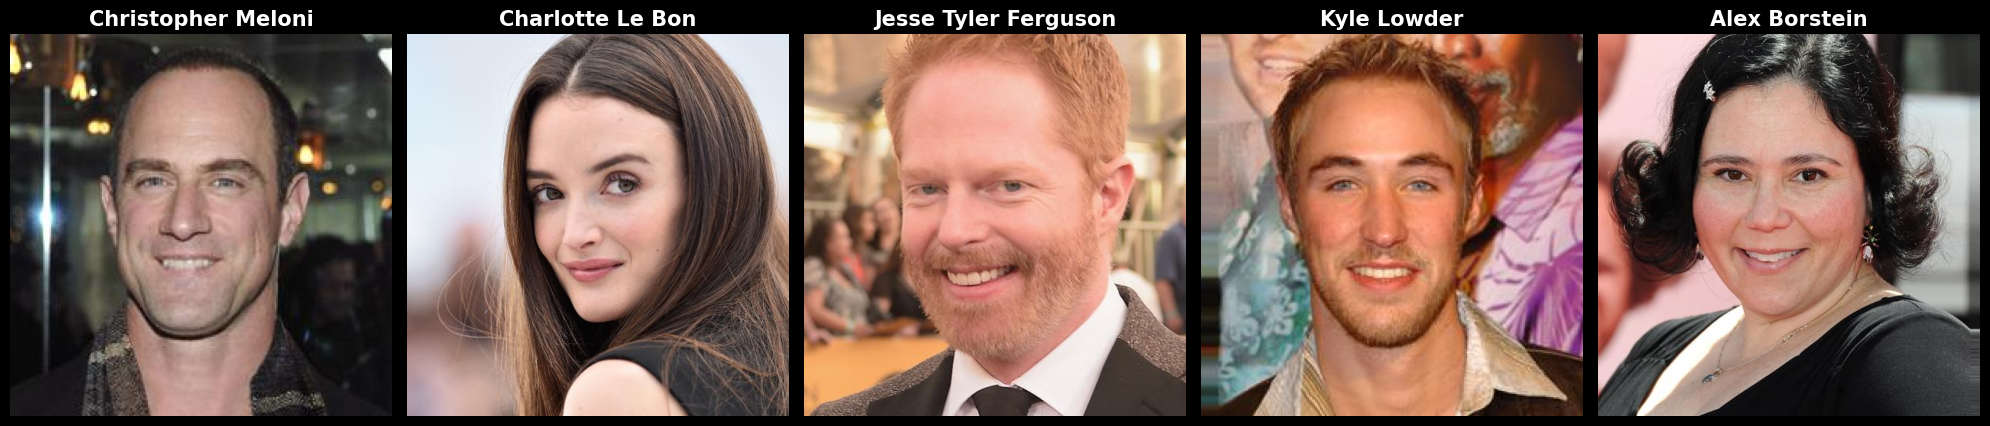

In [73]:
# Displaying 5 random images of celebrities
plt.figure(figsize=(20, 6))

for i in range(5):
    random_index = np.random.randint(0, len(train_df))  # Selecting a random index

    img_pixels = train_df["Image Pixels"][random_index]
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion

    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(train_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Getting Testing Images Pixels <a id='test_pix'></a>


In [74]:
# Loading the image pixels of the testing images from the path
test_df["Image Pixels"] = test_df["Full Img Path"].apply(
    lambda x: load_imgs(x, False, False)
)

In [75]:
# Dropping the Full Img Path column
test_df.drop("Full Img Path", axis=1, inplace=True)

In [76]:
# Displaying 5 random rows of the testing data
test_df.sample(5)

Name Age at Photo Gender  \
0   Abdelrahman Saaed           20      1   
2   Abdelrahman Saaed           20      1   
23      Mustafa Eslam           20      1   
20    Mohamed Youssef           19      1   
16     Mohamed Refaat           19      1   

                                         Image Pixels  
0   [[[29, 26, 18], [29, 26, 18], [32, 26, 19], [3...  
2   [[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...  
23  [[[135, 133, 132], [133, 131, 130], [129, 127,...  
20  [[[255, 255, 255], [255, 255, 255], [255, 255,...  
16  [[[98, 104, 109], [101, 107, 112], [103, 112, ...

In [77]:
# Describing the testing data
test_df.describe()

Name Age at Photo Gender  \
count               28           28     28   
unique              12            3      2   
top     Mohamed Refaat           20      1   
freq                 4           16     26   

                                             Image Pixels  
count                                                  28  
unique                                                 28  
top     [[[29, 26, 18], [29, 26, 18], [32, 26, 19], [3...  
freq                                                    1

In [78]:
# Displaying the datatype of the image pixels column of the testing data
print("Datatype of the image pixels column:", type(test_df["Image Pixels"][0]))

Datatype of the image pixels column: <class 'numpy.ndarray'>


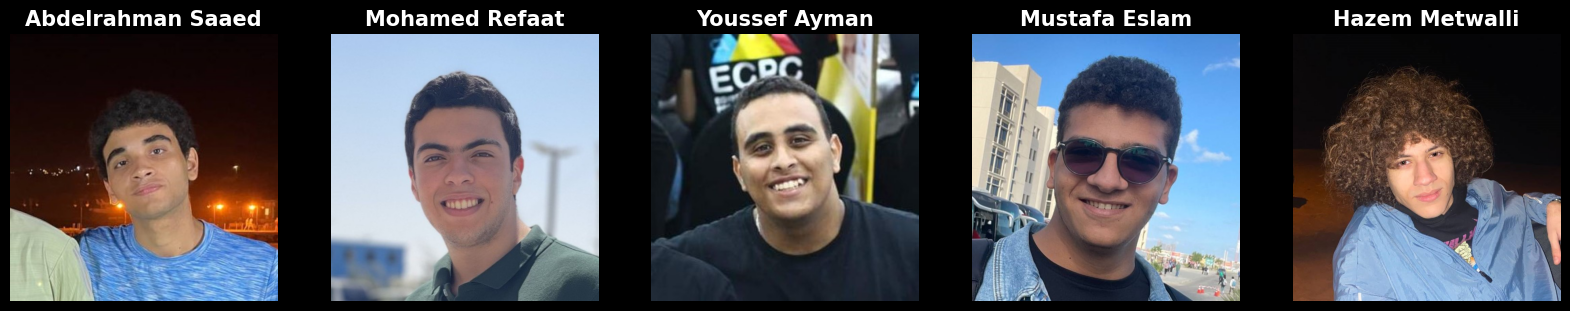

In [79]:
# Displaying 5 random test images
plt.figure(figsize=(20, 6))

# Selecting 5 unique random indices
random_indices = np.random.choice(test_df.index, size=5, replace=False)

for i, random_index in enumerate(random_indices):
    img_pixels = test_df.loc[random_index, "Image Pixels"]
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(test_df.loc[random_index, "Name"], fontsize=15, fontweight="bold")
    plt.axis("off")

### Finding the Training Faces Representations<a id='train_norm'></a>

In [80]:
# Resizing and normalizing the training images
tic = time.time()

train_df["Normalized Image Pixels"] = train_df["Image Pixels"].apply(
    get_face_representation
)
toc = time.time()

train_img_resize_time = str(timedelta(seconds=round(toc - tic, 2)))
print("Time taken to resize and normalize the training images:", train_img_resize_time)

Time taken to resize and normalize the training images: 0:01:49.070000


In [81]:
# Getting the number of features in the training data after resizing and normalizing the image pixels
train_features_len = len(train_df.columns)
print(
    "Total number of training features after resizing and normalizing the image pixels:",
    train_features_len,
)

Total number of training features after resizing and normalizing the image pixels: 6


In [82]:
train_records_len = len(train_df)  # Updating the total number of records
train_df.dropna(inplace=True)  # Dropping any rows with null values
print(
    "Total number of records with null values removed:",
    train_records_len - len(train_df),
)
train_records_len = len(train_df)  # Updating the total number of records
train_df.reset_index(drop=True, inplace=True)  # Resetting the index of the dataframe

Total number of records with null values removed: 895


In [83]:
# Displaying 5 random rows of the training data
train_df.sample(5)

Celebrity Name  Gender  Current Age  Age at Photo  \
755       Colton Haynes       1           35            26   
3240        Adam Pascal       1           53            34   
5759     Leticia Dolera       0           42            21   
2654   Janeane Garofalo       0           59            34   
10015   Laurence Harvey       1           95            33   

                                            Image Pixels  \
755    [[[58, 54, 53], [58, 54, 53], [58, 54, 53], [5...   
3240   [[[224, 207, 186], [224, 207, 186], [222, 207,...   
5759   [[[201, 179, 161], [200, 178, 160], [199, 177,...   
2654   [[[219, 216, 178], [224, 221, 183], [228, 225,...   
10015  [[[50, 50, 50], [54, 54, 54], [53, 53, 53], [4...   

                                 Normalized Image Pixels  
755    [[[[0.7254902  0.7019608  0.67058825], [0.7254...  
3240   [[[[0.79607844 0.7019608  0.48235297], [0.7882...  
5759   [[[[0.5529412  0.36470592 0.20784318], [0.5529...  
2654   [[[[0.7882353  0.7647059  0.45882356], [0.8117...  
10015  [[[[-0.67058825 -0.67058825 -0.67058825], [-0....

In [84]:
# Describing the training data
train_df.describe()

Gender   Current Age  Age at Photo
count  10522.000000  10522.000000  10522.000000
mean       0.565387     55.229519     35.836723
std        0.495730     17.323495     14.279268
min        0.000000     16.000000      0.000000
25%        0.000000     43.000000     26.000000
50%        1.000000     52.000000     34.000000
75%        1.000000     65.000000     44.000000
max        1.000000    147.000000    133.000000

In [85]:
# Displaying the datatype of the normalized training image pixels column
print(
    "Datatype of the normalized training image pixels column:",
    type(train_df["Normalized Image Pixels"][0]),
)

Datatype of the normalized training image pixels column: <class 'numpy.ndarray'>


In [86]:
# Showing the dimensions of the normalized training images
print(
    "Dimensions of the training image pixels:",
    train_df["Normalized Image Pixels"][2].shape,
)

Dimensions of the training image pixels: (1, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


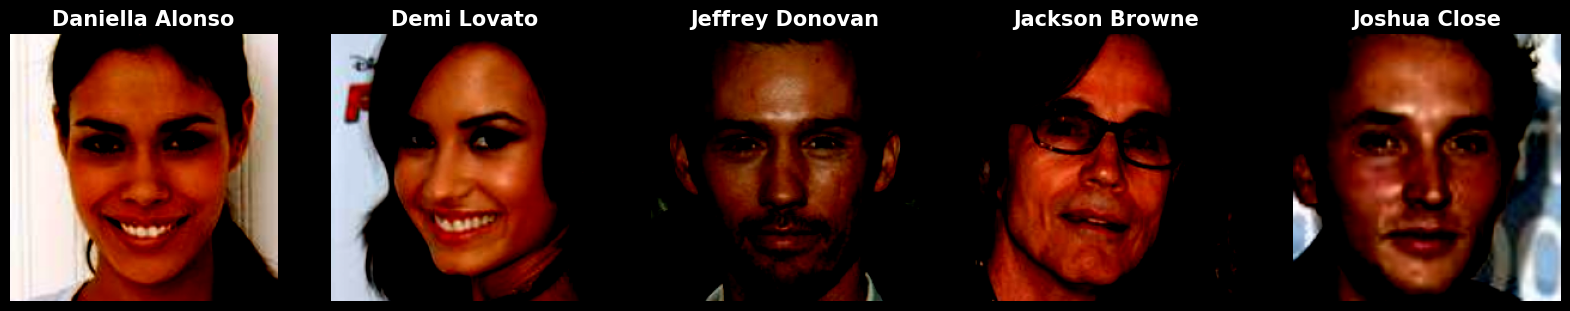

In [87]:
# Displaying 5 random normalized images of celebrities
plt.figure(figsize=(20, 6))
for i in range(5):
    random_index = np.random.randint(0, len(train_df))  # Selecting a random index
    img_pixels = train_df["Normalized Image Pixels"][random_index]
    img_pixels = img_pixels[0]  # Removing the extra dimension
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(train_df["Celebrity Name"][random_index], fontsize=15, fontweight="bold")
    plt.axis("off")

### Finding the Testing Faces Representations<a id='test_norm'></a>

In [89]:
# Resizing and normalizing the testing images
test_df["Normalized Image Pixels"] = test_df["Image Pixels"].apply(
    lambda x: get_face_representation(x, False)
)

In [90]:
test_records_len = len(test_df)  # Updating the total number of records
test_df.dropna(inplace=True)  # Dropping any rows with null values
print(
    "Total number of records with null values removed:",
    test_records_len - len(test_df),
)
test_records_len = len(test_df)  # Updating the total number of records
test_df.reset_index(drop=True, inplace=True)  # Resetting the index of the dataframe

Total number of records with null values removed: 5


In [91]:
# Displaying 5 random rows of the testing data
test_df.sample(5)

Name Age at Photo Gender  \
7        Fouad Ouda           20      1   
8        Fouad Ouda           20      1   
22    Youssef Ayman           20      1   
13   Mohamed Refaat           19      1   
16  Mohamed Youssef           19      1   

                                         Image Pixels  \
7   [[[3, 3, 9], [3, 3, 9], [4, 4, 10], [4, 4, 10]...   
8   [[[21, 12, 9], [23, 14, 11], [25, 16, 13], [18...   
22  [[[215, 165, 119], [215, 165, 119], [215, 165,...   
13  [[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...   
16  [[[255, 255, 255], [255, 255, 255], [255, 255,...   

                              Normalized Image Pixels  
7   [[[[-0.9529412  -0.9529412  -0.85882354], [-0....  
8   [[[[-0.6392157  -0.6784314  -0.67058825], [-0....  
22  [[[[0.73333335 0.4039216  0.06666672], [0.7333...  
13  [[[[-0.94509804 -0.94509804 -0.8352941 ], [-0....  
16  [[[[1. 1. 1.], [0.9843137 1.        1.       ]...

In [92]:
# Describing the testing data
test_df.describe()

Name Age at Photo Gender  \
count               23           23     23   
unique              11            2      1   
top     Mohamed Refaat           20      1   
freq                 4           16     23   

                                             Image Pixels  \
count                                                  23   
unique                                                 23   
top     [[[29, 26, 18], [29, 26, 18], [32, 26, 19], [3...   
freq                                                    1   

                                  Normalized Image Pixels  
count                                                  23  
unique                                                 23  
top     [[[[0.81960785 0.6862745  0.5372549 ], [0.7490...  
freq                                                    1

In [93]:
# Displaying the datatype of the normalized testing image pixels column
print(
    "Datatype of the normalized testing image pixels column:",
    type(test_df["Normalized Image Pixels"][0]),
)

Datatype of the normalized testing image pixels column: <class 'numpy.ndarray'>


In [94]:
# Showing the dimensions of the normalized testing images
print(
    "Dimensions of the testing image pixels:",
    test_df["Normalized Image Pixels"][2].shape,
)

Dimensions of the testing image pixels: (1, 224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


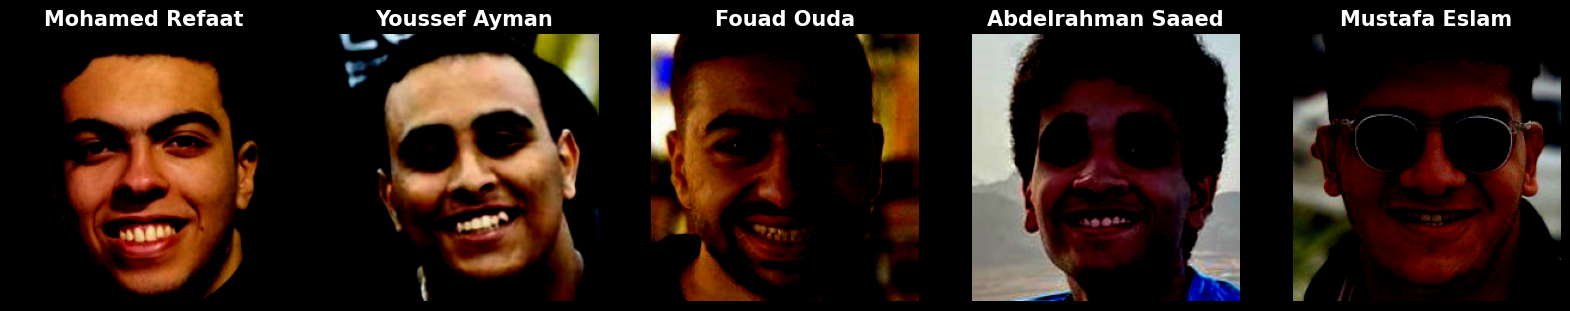

In [97]:
# Displaying 5 random normalized test images
plt.figure(figsize=(20, 6))

# Selecting 5 unique random indices
random_indices = np.random.choice(test_df.index, size=5, replace=False)

for i, random_index in enumerate(random_indices):
    img_pixels = test_df.loc[random_index, "Normalized Image Pixels"]
    img_pixels = img_pixels[0]  # Removing the extra dimension
    img_pixels = cv2.cvtColor(img_pixels, cv2.COLOR_BGR2RGB)  # Apply color conversion
    plt.subplot(1, 5, i + 1)
    plt.imshow(img_pixels)
    plt.title(test_df.loc[random_index, "Name"], fontsize=15, fontweight="bold")
    plt.axis("off")

## Neural Network Construction<a id='cnn'></a>


### Building the Network (Vgg Face Descriptor)<a id='bld'></a>

In [98]:
# Initializing the vgg face descriptor model for face recognition
model = Sequential()

# Adding the first chunk of layers to the model as per the vgg face descriptor model architecture
# (64 filters per convolutional layer (2))
# Before every convolutional layer in chunks 1 to 5, a zero padding layer is added to preserve more spatial information
# At the end of chunks 1 to 5, a max pooling layer is added to reduce the spatial dimensions of the image

# Adding the first zero padding to the input image pixels making them 226 x 226 to preserve more spatial information
model.add(ZeroPadding2D((1, 1), input_shape=(224, 224, 3)))
# Adding the first convolutional layer with 64 filters of size 3 x 3 and relu activation function
model.add(Convolution2D(64, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, (3, 3), activation="relu"))
model.add(
    MaxPooling2D((2, 2), strides=(2, 2))
)  # Adding the first max pooling layer with a pool size of 2 x 2 and stride of 2 x 2 to reduce
# the spatial dimensions of the image

# Adding the second chunk of layers to the model as per the vgg face descriptor model architecture
# (128 filters per convolutional layer (2))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the third chunk of layers to the model as per the vgg face descriptor model architecture
# (256 filters per convolutional layer (3))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the fourth chunk of layers to the model as per the vgg face descriptor model architecture
# (512 filters per convolutional layer (3))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the fifth chunk of layers to the model as per the vgg face descriptor model architecture
# (512 filters per convolutional layer (3))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Adding the sixth chunk of layers to the model as per the vgg face descriptor model architecture
# (4096 neurons per dense layer (2))

model.add(
    Convolution2D(4096, (7, 7), activation="relu")
)  # Adding the first 'dense' layer with 4096 neurons and relu activation function this is
# considered a dense layer because it has a kernel size of 7 x 7 which is the same as the spatial dimensions of the image
model.add(
    Dropout(0.5)
)  # Adding a dropout layer with a dropout rate of 50% to prevent overfitting
model.add(Convolution2D(4096, (1, 1), activation="relu"))
model.add(Dropout(0.5))

# Adding the seventh chunk of layers to the model as per the vgg face descriptor model architecture
# (2622 neurons per dense layer (1))

model.add(Convolution2D(2622, (1, 1)))
model.add(
    Flatten()
)  # Adding a flatten layer to flatten the output of the previous layer to a 1D vector (Feature Vector)

In [99]:
# Displaying the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     7

### Importing the Model's Weights<a id='wghts'></a>

In [100]:
# Check if the user wants to download the weights of the model
download_weights = False

In [101]:
# Downloading the imdb_crop dataset from the link into the current/Data directory
if download_weights == False:
    print("Vgg face descriptor Model weights not downloaded. Please download the weights, if you already have the weights ignore this message.")
else:
    !wget https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5

Vgg face descriptor Model weights not downloaded. Please download the weights, if you already have the weights ignore this message.


In [102]:
# Load Vgg Face Model Weights
model.load_weights("Models/vgg_face_weights.h5")

## Predicting the Faces' Feature Map<a id='map'></a>

In [103]:
def get_face_vector(norm_img_pixels):
    """
    Get the face vector representation of the normalized image pixels.

    Parameters:
    -   norm_img_pixels (ndarray): The normalized image pixels as a NumPy array.

    Returns:
    -   face_vector (ndarray): The face vector representation of the image pixels.
    """

    face_vector = model.predict(norm_img_pixels, verbose=1)[0, :]

    return face_vector

### Predicting the Faces' Feature Map for the Training Images<a id='train_map'></a>

In [104]:
# Getting the face vector representation of the normalized training image pixels
tic = time.time()
train_df["Face Vector"] = train_df["Normalized Image Pixels"].apply(get_face_vector)
toc = time.time()

train_face_vector_time = str(timedelta(seconds=round(toc - tic, 2)))
print("\nTime taken to get face vectors:", train_face_vector_time[:-3])

1/1 [==============================] - 0s 23ms/step

Time taken to get face vectors: 0:17:23.800


In [105]:
# Displaying 5 random rows of the training data
train_df.sample(5)

Celebrity Name  Gender  Current Age  Age at Photo  \
4491     Jenna Coleman       0           37            18   
5387     Ronee Blakley       0           78            38   
1105      Alex Meneses       0           58            34   
102   Juliette Binoche       0           59            37   
1206        Leah Pipes       0           35            20   

                                           Image Pixels  \
4491  [[[59, 58, 54], [58, 57, 53], [57, 56, 52], [5...   
5387  [[[7, 7, 7], [7, 7, 7], [7, 7, 7], [7, 7, 7], ...   
1105  [[[248, 239, 236], [248, 239, 236], [248, 239,...   
102   [[[138, 135, 130], [138, 135, 130], [138, 135,...   
1206  [[[22, 22, 22], [22, 22, 22], [22, 22, 22], [2...   

                                Normalized Image Pixels  \
4491  [[[[-0.67058825 -0.54509807 -0.45098037], [-0....   
5387  [[[[-0.73333335 -0.73333335 -0.73333335], [-0....   
1105  [[[[0.7411765  0.78039217 0.8509804 ], [0.7098...   
102   [[[[0.12941182 0.10588241 0.07450986], [0.1215...   
1206  [[[[-0.9372549 -0.9372549 -0.9372549], [-0.929...   

                                            Face Vector  
4491  [0.014418079, -0.008614423, 0.004469162, 0.044...  
5387  [0.051754892, -0.00413865, 0.0055466862, 0.038...  
1105  [0.005675355, 0.03284481, 0.011477348, 0.02691...  
102   [0.0071531455, -0.010396175, 0.0062630004, 0.0...  
1206  [0.037284665, -0.017117172, 0.0075076926, 0.01...

In [106]:
# Describing the training data
train_df.describe()

Gender   Current Age  Age at Photo
count  10522.000000  10522.000000  10522.000000
mean       0.565387     55.229519     35.836723
std        0.495730     17.323495     14.279268
min        0.000000     16.000000      0.000000
25%        0.000000     43.000000     26.000000
50%        1.000000     52.000000     34.000000
75%        1.000000     65.000000     44.000000
max        1.000000    147.000000    133.000000

In [107]:
# Displaying the datatype of the face vector column of the training data
print("Datatype of the face vector column:", type(train_df["Face Vector"][0]))

Datatype of the face vector column: <class 'numpy.ndarray'>


### Predicting the Faces' Feature Map for the Testing Images<a id='test_map'></a>

In [108]:
# Getting the face vector representation of the normalized testing image pixels
tic = time.time()
test_df["Face Vector"] = test_df["Normalized Image Pixels"].apply(get_face_vector)
toc = time.time()

test_face_vector_time = str(timedelta(seconds=round(toc - tic, 2)))
print("Time taken to get face vectors:", test_face_vector_time[:-3])

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 13ms/step
Time taken to get face vectors: 0:00:02.450


In [109]:
# Displaying 5 random rows of the testing data
test_df.sample(5)

Name Age at Photo Gender  \
18      Mustafa Eslam           20      1   
2   Abdelrahman Saaed           20      1   
21      Youssef Ayman           20      1   
19      Mustafa Eslam           20      1   
6          Fouad Ouda           20      1   

                                         Image Pixels  \
18  [[[135, 133, 132], [133, 131, 130], [129, 127,...   
2   [[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...   
21  [[[60, 48, 38], [59, 47, 37], [59, 47, 37], [6...   
19  [[[254, 254, 254], [254, 254, 254], [254, 254,...   
6   [[[93, 117, 129], [90, 114, 126], [86, 110, 12...   

                              Normalized Image Pixels  \
18  [[[[-0.40392154 -0.4823529  -0.56078434], [-0....   
2   [[[[-0.96862745 -0.9529412  -0.8117647 ], [-0....   
21  [[[[-0.7176471  -0.78039217 -0.9137255 ], [-0....   
19  [[[[0.77254903 0.84313726 0.81960785], [0.7803...   
6   [[[[0.92156863 0.9529412  0.9607843 ], [0.9372...   

                                          Face Vector  
18  [0.014332768, 0.01655483, 0.02937874, 0.008241...  
2   [0.021920538, 0.04413207, 0.035032142, 0.00801...  
21  [0.018699765, 0.015869815, 0.026980437, 0.0111...  
19  [0.030304302, 0.018653031, 0.017314004, 0.0176...  
6   [0.0094807595, -0.01338739, 0.021427548, 0.017...

In [110]:
# Describing the testing data
test_df.describe()

Name Age at Photo Gender  \
count               23           23     23   
unique              11            2      1   
top     Mohamed Refaat           20      1   
freq                 4           16     23   

                                             Image Pixels  \
count                                                  23   
unique                                                 23   
top     [[[29, 26, 18], [29, 26, 18], [32, 26, 19], [3...   
freq                                                    1   

                                  Normalized Image Pixels  \
count                                                  23   
unique                                                 23   
top     [[[[0.81960785 0.6862745  0.5372549 ], [0.7490...   
freq                                                    1   

                                              Face Vector  
count                                                  23  
unique                                                 23  
top     [0.038963445, 0.054113783, 0.037888356, 0.0019...  
freq                                                    1

In [111]:
# Displaying the datatype of the face vector column of the testing data
print("Datatype of the face vector column:", type(test_df["Face Vector"][0]))

Datatype of the face vector column: <class 'numpy.ndarray'>


## Finding Similarities Between the Images<a id='sim'></a>

In [112]:
def cosine_similarity(vec1, vec2):
    """
    Calculates the cosine similarity between two vectors.

    Parameters:
    -   vec1 (numpy.ndarray): The first vector.
    -   vec2 (numpy.ndarray): The second vector.

    Returns:
    float: The cosine similarity between vec1 and vec2.
    """
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

In [114]:
j = 1  # Index of the image to be displayed



def get_top_3_similar_celebs(img_vector, verbose=True):
    """

    Calculates the cosine similarity between an image vector and the celebrities' face vectors,

    and returns the top 3 most similar celebrities.


    Args:

    -   img_vector (array-like): The vector representation of the image.


    Returns:

    -   pandas.DataFrame: A dataframe containing the top 3 most similar celebrities to the image,

        sorted by similarity in descending order.
    """

    # Creating a dataframe to store the cosine similarity between the image and the celebrities

    similarity_df = pd.DataFrame(columns=["Name", "Similarity"])


    # Calculating the cosine similarity between the image and the celebrities

    for i in range(len(train_df)):

        similarity_df.loc[i, "Name"] = train_df.loc[i, "Celebrity Name"]

        similarity_df.loc[i, "Similarity"] = cosine_similarity(

            img_vector, train_df.loc[i, "Face Vector"]

        )


    # Sorting the dataframe by the similarity column in descending order

    similarity_df.sort_values(by="Similarity", ascending=False, inplace=True)


    # Getting the top 3 most similar celebrities to the image

    top_3_similar_celebs = similarity_df.iloc[:3, :]


    # Printing the image number being loaded if verbose is True

    global j


    if verbose == True:

        print("Calculating similarity for img number:", i, end="\r")


    j += 1  # Incrementing the image number


    return top_3_similar_celebs

### Finding Similarities between the Celebrities & the Testing Images <a id='test_sim'></a>

In [115]:
# Getting the top 3 most similar celebrities to the testing images
tic = time.time()
test_df["Top 3 Similar Celebs"] = test_df["Face Vector"].apply(get_top_3_similar_celebs)
toc = time.time()

test_similarity_time = str(timedelta(seconds=round(toc - tic, 2)))
print(
    "Time taken to get top 3 similar celebrities for each testing image:",
    test_similarity_time,
)

Time taken to get top 3 similar celebrities for each testing image: 0:01:49.470000


In [116]:
# Displaying 5 random rows of the testing data
test_df.sample(5)

Name Age at Photo Gender  \
2   Abdelrahman Saaed           20      1   
9      Hazem Metwalli           20      1   
1   Abdelrahman Saaed           20      1   
22      Youssef Ayman           20      1   
0   Abdelrahman Saaed           20      1   

                                         Image Pixels  \
2   [[[3, 2, 11], [3, 2, 11], [3, 2, 11], [3, 2, 1...   
9   [[[253, 253, 235], [252, 252, 234], [251, 252,...   
1   [[[231, 232, 223], [231, 232, 223], [231, 232,...   
22  [[[215, 165, 119], [215, 165, 119], [215, 165,...   
0   [[[29, 26, 18], [29, 26, 18], [32, 26, 19], [3...   

                              Normalized Image Pixels  \
2   [[[[-0.96862745 -0.9529412  -0.8117647 ], [-0....   
9   [[[[-0.49019605 -0.5058824  -0.5137255 ], [-0....   
1   [[[[0.8039216  0.8352941  0.79607844], [0.8039...   
22  [[[[0.73333335 0.4039216  0.06666672], [0.7333...   
0   [[[[0.81960785 0.6862745  0.5372549 ], [0.7490...   

                                          Face Vector  \
2   [0.021920538, 0.04413207, 0.035032142, 0.00801...   
9   [0.031262957, 0.025722258, 0.02745109, 0.00149...   
1   [0.038955767, 0.051030513, 0.03287097, -0.0043...   
22  [0.03353987, 0.055179726, 0.006176977, 0.01966...   
0   [0.038963445, 0.054113783, 0.037888356, 0.0019...   

                                 Top 3 Similar Celebs  
2                      Name Similarity
115        ...  
9                      Name Similarity
9674       ...  
1                      Name Similarity
8095       ...  
22                Name Similarity
3988        Chin...  
0                  Name Similarity
220   Xiaogang ...

In [117]:
# Describing the testing data
test_df.describe()

Name Age at Photo Gender  \
count               23           23     23   
unique              11            2      1   
top     Mohamed Refaat           20      1   
freq                 4           16     23   

                                             Image Pixels  \
count                                                  23   
unique                                                 23   
top     [[[29, 26, 18], [29, 26, 18], [32, 26, 19], [3...   
freq                                                    1   

                                  Normalized Image Pixels  \
count                                                  23   
unique                                                 23   
top     [[[[0.81960785 0.6862745  0.5372549 ], [0.7490...   
freq                                                    1   

                                              Face Vector  \
count                                                  23   
unique                                                 23   
top     [0.038963445, 0.054113783, 0.037888356, 0.0019...   
freq                                                    1   

                                     Top 3 Similar Celebs  
count                                                  23  
unique                                                 23  
top                    Name Similarity
220   Xiaogang ...  
freq                                                    1

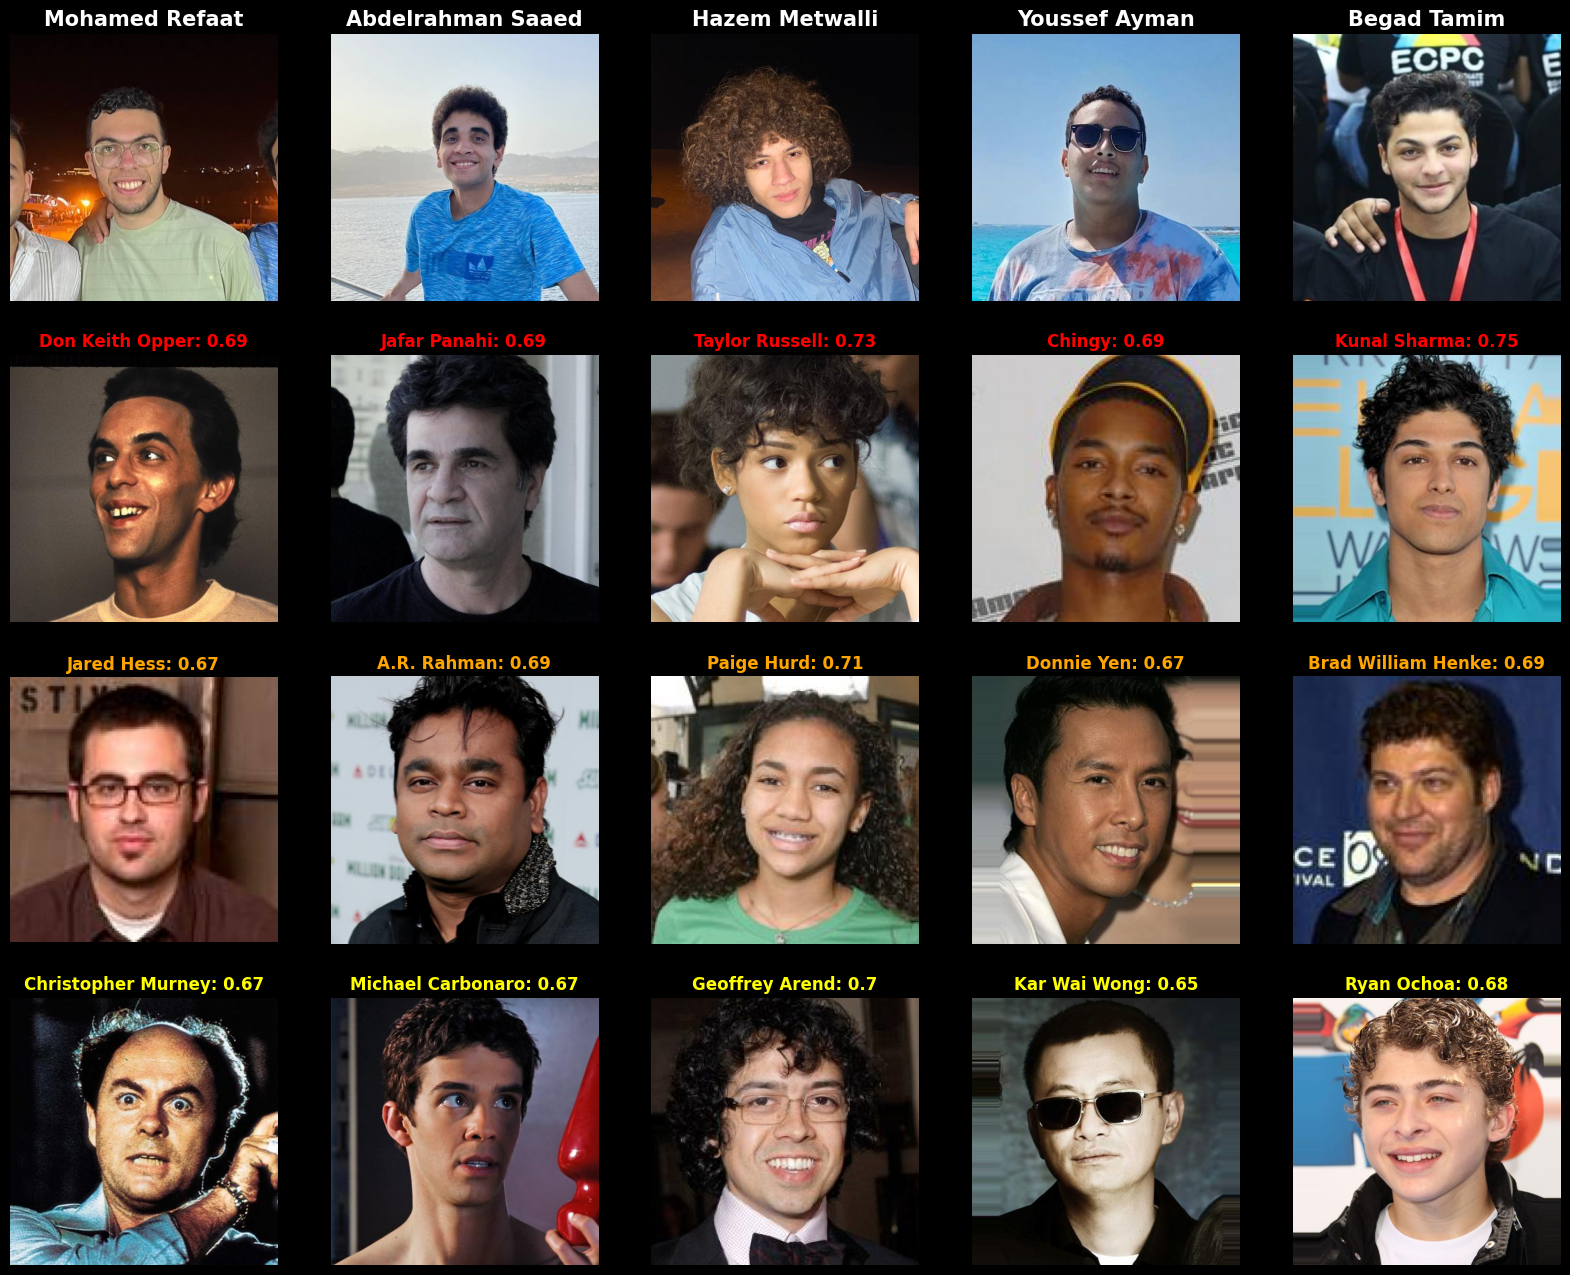

In [121]:
# Displaying the top 3 most similar celebrities to 5 random testing images along with their similarity score
plt.figure(figsize=(20, 16))

# Selecting 5 random indices
random_indices = np.random.choice(test_df.index, size=5, replace=False)

for i, random_index in enumerate(random_indices):
    test_img_pixels = test_df.loc[
        random_index, "Image Pixels"
    ]  # Getting the test image pixels
    test_img_pixels = cv2.cvtColor(
        test_img_pixels, cv2.COLOR_BGR2RGB
    )  # Apply color conversion

    plt.subplot(4, 5, i + 1)
    plt.imshow(test_img_pixels)
    plt.title(test_df.loc[random_index, "Name"], fontsize=15, fontweight="bold")
    plt.axis("off")

    # Creating a list of colors for the similarity scores
    colors = ["red", "orange", "yellow"]

    # Displaying the top 3 most similar celebrities to the test image
    for j in range(3):
        celeb_img_pixels = train_df[
            train_df["Celebrity Name"]
            == test_df.loc[random_index, "Top 3 Similar Celebs"].iloc[j, 0]
        ]["Image Pixels"].iloc[
            0
        ]  # Getting the celebrity image pixels

        celeb_img_pixels = cv2.cvtColor(
            celeb_img_pixels, cv2.COLOR_BGR2RGB
        )  # Apply color conversion

        plt.subplot(4, 5, 6 + i + 5 * j)
        plt.imshow(celeb_img_pixels)

        similarity_score = test_df.loc[random_index, "Top 3 Similar Celebs"].iloc[
            j, 1
        ]  # Getting the similarity score
        similarity_score = float(
            similarity_score
        )  # Converting the similarity score to float
        similarity_score = round(
            similarity_score, 2
        )  # Rounding the similarity score to 2 decimal places

        plt.title(
            f"{test_df.loc[random_index, 'Top 3 Similar Celebs'].iloc[j, 0]}: {similarity_score}",
            fontsize=12,
            fontweight="bold",
            color=colors[j],
        )

        plt.axis("off")

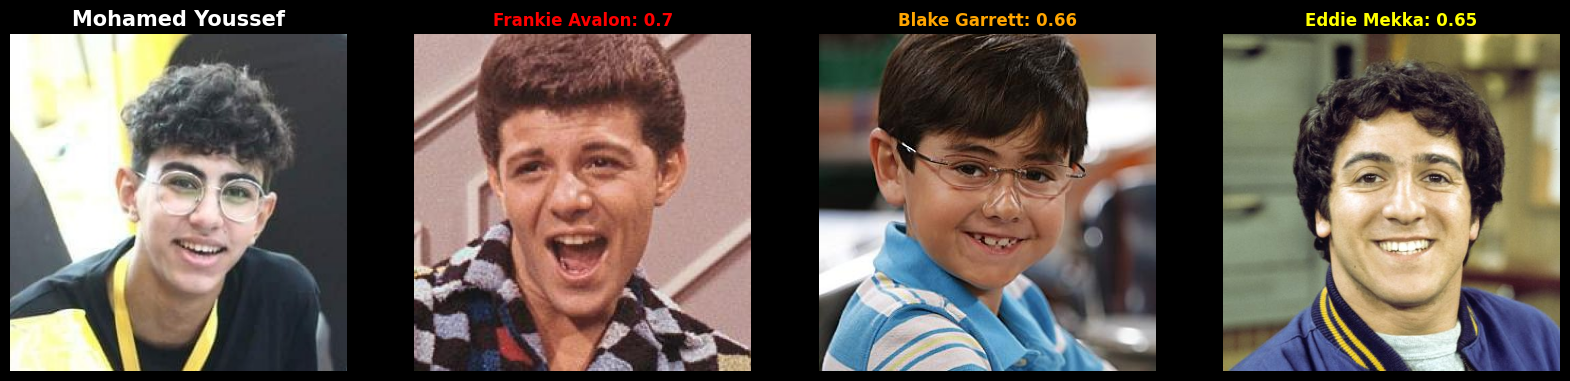

In [122]:
# Displaying the top 3 most similar celebrities to a specific test image along with their similarity score using the test image name
test_img_name = input("Enter the name of the test image: ").title().strip()

# Get the index of the test image
test_img_index = test_df[test_df["Name"] == test_img_name].index[0]

test_img_pixels = test_df[test_df["Name"] == test_img_name]["Image Pixels"].iloc[
    0
]  # Getting the image pixels of the test image

test_img_pixels = cv2.cvtColor(
    test_img_pixels, cv2.COLOR_BGR2RGB
)  # Apply color conversion

plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.imshow(test_img_pixels)
plt.title(test_img_name, fontsize=15, fontweight="bold")
plt.axis("off")

# Displaying the top 3 most similar celebrities to the test image
for j in range(3):
    celeb_img_pixels = train_df[
        train_df["Celebrity Name"]
        == test_df.loc[test_img_index, "Top 3 Similar Celebs"].iloc[j, 0]
    ]["Image Pixels"].iloc[
        0
    ]  # Getting the image pixels of the celebrity

    celeb_img_pixels = cv2.cvtColor(
        celeb_img_pixels, cv2.COLOR_BGR2RGB
    )  # Apply color conversion

    plt.subplot(1, 4, j + 2)
    plt.imshow(celeb_img_pixels)

    similarity_score = test_df.loc[test_img_index, "Top 3 Similar Celebs"].iloc[
        j, 1
    ]  # Getting the similarity score
    similarity_score = float(
        similarity_score
    )  # Converting the similarity score to float
    similarity_score = round(
        similarity_score, 2
    )  # Rounding the similarity score to 2 decimal places

    plt.title(
        f"{test_df.loc[test_img_index, 'Top 3 Similar Celebs'].iloc[j, 0]}: {similarity_score}",
        fontsize=12,
        fontweight="bold",
        color=colors[j],
    )

    plt.axis("off")

### Finding Similarities between the Celebrities & Each Other <a id='train_sim'></a>

In [123]:
# Get the similarity scores of the top 3 most similar celebrities to another celebrity using the celebrity name
celeb_name = input("Enter the name of the celebrity: ").title().strip()

# Get the index of the celebrity
celeb_index = train_df[train_df["Celebrity Name"] == celeb_name].index[0]

# Creating a dataframe to store the cosine similarity between the celebrity and the celebrities
similarity_df = pd.DataFrame(columns=["Name", "Similarity"])

# Calculating the cosine similarity between the celebrity and the celebrities
for i in range(len(train_df)):
    similarity_df.loc[i, "Name"] = train_df.loc[i, "Celebrity Name"]
    similarity_df.loc[i, "Similarity"] = cosine_similarity(
        train_df.loc[celeb_index, "Face Vector"], train_df.loc[i, "Face Vector"]
    )

# Sorting the dataframe by the similarity column in descending order
similarity_df.sort_values(by="Similarity", ascending=False, inplace=True)

# Getting the top 3 most similar celebrities to the celebrity
top_3_similar_celebs = similarity_df.iloc[:3, :]

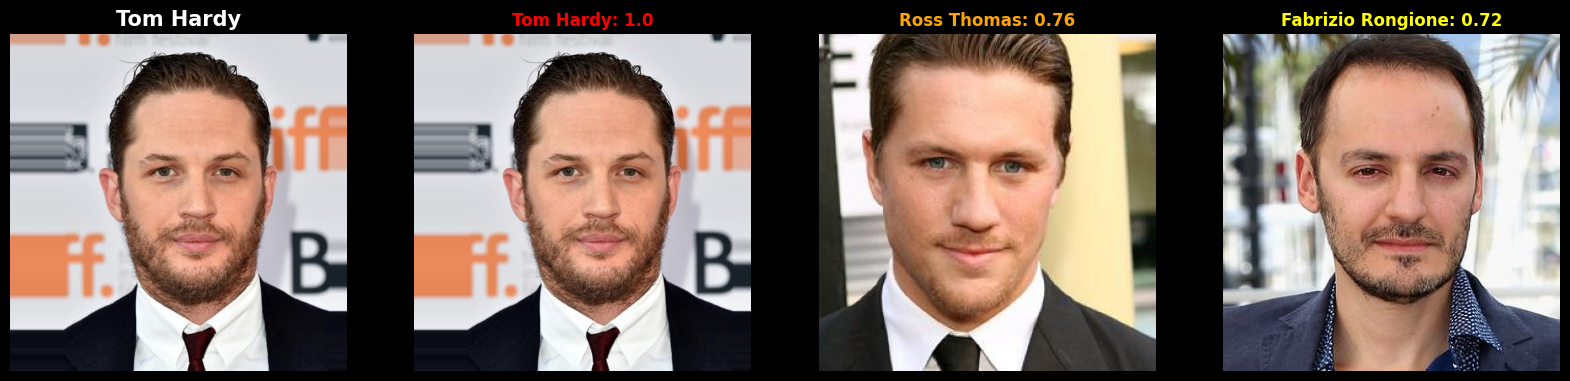

In [124]:
# Displaying the top 3 most similar celebrities to a specific celebrity along with their similarity score using the celebrity name

# Get the index of the celebrity
celeb_index = train_df[train_df["Celebrity Name"] == celeb_name].index[0]

# Get the image pixels of the celebrity
celeb_img_pixels = train_df[train_df["Celebrity Name"] == celeb_name][
    "Image Pixels"
].iloc[0]

celeb_img_pixels = cv2.cvtColor(
    celeb_img_pixels, cv2.COLOR_BGR2RGB
)  # Apply color conversion

plt.figure(figsize=(20, 6))
plt.subplot(1, 4, 1)
plt.imshow(celeb_img_pixels)
plt.title(celeb_name, fontsize=15, fontweight="bold")
plt.axis("off")

# Displaying the top 3 most similar celebrities to the celebrity
for j in range(3):
    celeb_img_pixels = train_df[
        train_df["Celebrity Name"] == top_3_similar_celebs.iloc[j, :]["Name"]
    ]["Image Pixels"].iloc[
        0
    ]  # Getting the image pixels of the celebrity

    celeb_img_pixels = cv2.cvtColor(
        celeb_img_pixels, cv2.COLOR_BGR2RGB
    )  # Apply color conversion

    plt.subplot(1, 4, j + 2)
    plt.imshow(celeb_img_pixels)

    similarity_score = top_3_similar_celebs.iloc[j, :][
        "Similarity"
    ]  # Getting the similarity score
    similarity_score = float(
        similarity_score
    )  # Converting the similarity score to float
    similarity_score = round(
        similarity_score, 2
    )  # Rounding the similarity score to 2 decimal places

    plt.title(
        f"{top_3_similar_celebs.iloc[j, :]['Name']}: {similarity_score}",
        fontsize=12,
        fontweight="bold",
        color=colors[j],
    )

    plt.axis("off")

## Getting the Predictions in Real Time <a id='real_time'></a>

In [126]:
cap = cv2.VideoCapture(0)  # Initialize the default camera
celebrity_img_size = (
    150  # Width of the celebrity image to be displayed in the corner of the frame
)

while True:
    _, frame = cap.read()  # Capture frame-by-frame

    # Inverting the frame horizontally
    frame = cv2.flip(frame, 1)

    faces = face_cascade.detectMultiScale(
        frame, 1.3, 5
    )  # Detect faces in the frame using the face cascade classifier

    # Displaying a message if no face is detected
    if len(faces) == 0:
        cv2.putText(
            frame,
            "No face detected",
            (10, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.1,
            (36, 255, 12),
            2,
        )

    # Displaying a message if multiple faces are detected
    elif len(faces) > 1:
        cv2.putText(
            frame,
            "Multiple faces detected",
            (10, 50),
            cv2.FONT_HERSHEY_SIMPLEX,
            1.1,
            (36, 255, 12),
            2,
        )

    # If only one face is detected then proceed
    elif len(faces) == 1:
        # Looping through the x, y, w, h coordinates of the detected faces
        for x, y, w, h in faces:
            if w > 0:
                # Draw a rectangle around the detected face
                cv2.rectangle(
                    frame,
                    (x, y),
                    (x + w, y + h),
                    (255, 0, 0),
                    2,
                )

                img_pixels = get_face_representation(
                    frame, False
                )  # Get the face representation of the detected face

                try:
                    face_vector = model.predict(img_pixels)[
                        0, :
                    ]  # Get the face vector representation of the detected face
                except:
                    continue # If no face is detected then continue

                # Creating a dataframe to store the cosine similarity between the detected face and the celebrities
                similarity_df = pd.DataFrame(columns=["Similarity"])

                # Calculating the cosine similarity between the detected face and the celebrities
                similarity_df["Similarity"] = train_df["Face Vector"].apply(
                    lambda x: cosine_similarity(face_vector, x)
                )

                # Getting the name of the celebrity with the highest similarity score
                max_similarity_index = similarity_df["Similarity"].idxmax()
                name = train_df.loc[max_similarity_index, "Celebrity Name"]
                similarity = similarity_df.loc[max_similarity_index, "Similarity"]

                # Getting the age of the celebrity with the highest similarity score
                age = train_df.loc[max_similarity_index, "Age at Photo"]

                # Get the image pixels of the celebrity
                celebrity_img = train_df[train_df["Celebrity Name"] == name][
                    "Image Pixels"
                ].iloc[0]

                # Resize the image pixels of the celebrity to the size of the detected face
                celebrity_img = cv2.resize(
                    celebrity_img,
                    (celebrity_img_size, celebrity_img_size),
                    interpolation=cv2.INTER_AREA,
                )

                # Display the name and similarity score of the celebrity
                cv2.putText(
                    frame,
                    f"{name}: {round(similarity * 100, 2)}%, Age: {age}",
                    (x - 200, y - 30),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (36, 255, 12),
                    2,
                )

                # Display the image of the celebrity in the bottom left corner of the frame
                frame[
                    frame.shape[0] - celebrity_img_size : frame.shape[0],
                    0:celebrity_img_size,
                ] = celebrity_img

    cv2.imshow("Frame", frame)  # Display the resulting frame

    if cv2.waitKey(1) & 0xFF == ord("q"):  # Press q to exit
        break

# When everything done, release the capture and destroy the windows
cap.release()
cv2.destroyAllWindows()